*Берутся видео с датасета `https://disk.yandex.ru/d/_vjY_E84Bs1p-Q`, обрезается лишнее(чтобы не было очень сильного дисбаланса классов), бьются на кадры, затем вручную в csv файл записываются метки каждого кадра, а также координаты бокса с человеком(если вдруг понадобится)*
Получившийся датасет лежит в `https://drive.google.com/drive/folders/1YTx-Rj6D7dj0WFRjYTJHJ6_gOz8KsCh5`

*Обрезаем видео*

In [3]:
pip install --trusted-host pypi.python.org moviepy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 KB 2.8 MB/s eta 0:00:002.3 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 4.7 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110747 sha256=8b8c4d8d25232cbaf772fc5fc06c37c6814ee1e1c4ab1f4a011f6618f135e00b
  Stored in directory: /home/anastasia/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install imageio-ffmpeg

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
start_time = 20 # seconds
end_time = 26
ffmpeg_extract_subclip("Shoplifting1.mp4", start_time, end_time, targetname="test.mp4")

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [20]:
def video_cut(video, start_time, end_time, count): # save cut video in the same directory
    ffmpeg_extract_subclip(video, start_time, end_time, targetname="Shoplifting"+str(count)+".mp4")

In [41]:
video_cut("/home/anastasia/Downloads/Shoplifting053_x264.mp4", 40, 48, 48)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [35]:
from moviepy.editor import VideoFileClip, vfx

def speed_up_video(input_video_path):
    output_path = input_video_path.replace('.mp4', '_speed.mp4')  
    video = VideoFileClip(input_video_path)
    speedup_video = video.fx(vfx.speedx, 1.5)  
    speedup_video.write_videofile(output_path, codec='libx264') 

*Получаем кадры*

In [72]:
import cv2
import os
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from PIL import Image
def receive_frames(video_path, counter):
    #video_path = 'Shoplifting5.mp4' 
    output_folder = 'output_frames_1'
    
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    
    #counter = 5
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        frame_name = f'frame_{counter}_{frame_count}.jpg'
        cv2.imwrite(os.path.join(output_folder, frame_name), frame)
    
    cap.release()
    #cv2.destroyAllWindows()
    return

In [73]:
for i in range(23, 49):
    video_name = f"Shoplifting{i}.mp4"
    receive_frames(video_name, i)

In [42]:
import pandas as pd
df_frames = pd.DataFrame(columns = ['file_name', 'labels'])

In [43]:
df_frames

,file_name,labels


*Добавляем в датафрейм новые кадры*

In [74]:
import os
image_dir = 'output_frames_1'
image_files = os.listdir(image_dir)
new_rows = []
for image_file in image_files:
        file_name = os.path.basename(image_file)
        if file_name not in df_frames['file_name'].values:
            new_row = {'file_name': file_name, 'labels': 0}
            new_rows.append({'file_name': file_name, 'labels': 0})
df_frames = pd.concat([df_frames, pd.DataFrame(new_rows)], ignore_index=True)

In [75]:
df_frames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11980 entries, 0 to 11979
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  11980 non-null  object
 1   labels     11980 non-null  object
dtypes: object(2)
memory usage: 187.3+ KB


*Проставляем метки на кадры краж*

In [134]:
def set_label(number_video, start_frame, finish_frame):
    for i in range(start_frame, finish_frame + 1):
        df_frames.loc[df_frames['file_name'] == f"frame_{number_video}_{i}.jpg", 'labels'] = 1

In [209]:
set_label(48, 96, 131)

*Просмотров кадров*

In [181]:
import os
from PIL import Image
import time
def show_video_frames(number_video):
    path = 'frames'
    images = [img for img in os.listdir(path) if img.endswith(".jpg") and f"frame_{number_video}" in img]
    #images.sort()
    
    for img in images:
        image_path = os.path.join(path, img)
        image = Image.open(image_path)
        image.show()
        time.sleep(0.25)
        image.close()
    return

<Axes: ylabel='Frequency'>

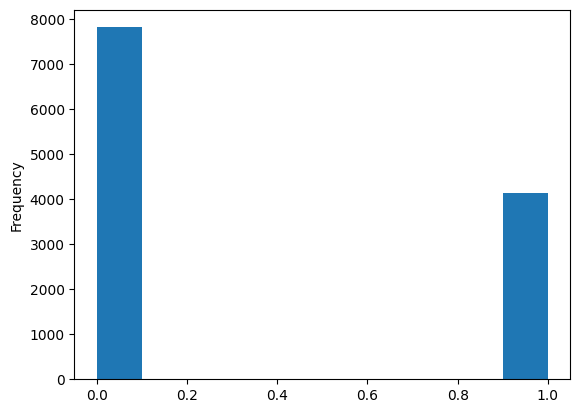

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt
df_frames['labels'].plot(kind='hist')

In [211]:
(df_frames['labels'] == 1).sum()

4153

In [212]:
df_frames.to_csv('metadata.csv', index=False)

*Получение координат yolo боксов*

In [9]:
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from PIL import Image
model = YOLO('yolov8n.pt')
model.classes = [0]
image_path = 'output_frames/frame_1.jpg'
save_directory = ''
results = model(source = image_path, classes=0, show = False, imgsz=640, conf=0.3, iou=0.4, save = True, save_dir=save_directory)


image 1/1 /home/anastasia/Desktop/project_testing/output_frames/frame_1.jpg: 480x640 3 persons, 83.0ms
Speed: 4.4ms preprocess, 83.0ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /home/anastasia/runs/detect/predict4


In [ ]:
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from PIL import Image

def crop_image(image, box):
    x_min, y_min, x_max, y_max = box
    width, height = image.size
    box_width = x_max - x_min
    box_height = y_max - y_min
    x_min_2 = max(0, x_min - box_width/3)
    y_min_2 = max(0, y_min - box_height/3)
    x_max_2 = min(width, x_max + box_width/3)
    y_max_2 = min(height, y_max + box_height/3)
    area = (x_min_2, y_min_2, x_max_2, y_max_2)
    cropped_img = image.crop(area)
    return cropped_img
    

def recieve_box(image):
    model = YOLO('yolov8n.pt')
    model.classes = [0]
    results = model(source = image, classes=0, show = False, imgsz=640, conf=0.3, iou=0.4, save = False)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
    cropped_images = []
    for box in boxes:
        cropped_images.append(crop_image(image, box))
    return cropped_images

model = YOLO('yolov8n.pt')
model.classes = [0]
image_path = '/content/drive/MyDrive/yolo_dataset/test/images/cam-pos-video-five_0mABuXZe_mp4-36_jpg.rf.9f17c4aa766ded211ed3a70d1728403f.jpg'
results = model(source = image_path, classes=0, show = False, imgsz=640, conf=0.3, iou=0.4, save = True)

import os
image_path = '/content/drive/MyDrive/yolo_dataset/test/images/cam-pos-video-five_0mABuXZe_mp4-36_jpg.rf.9f17c4aa766ded211ed3a70d1728403f.jpg'
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
save_dir = 'runs/detect/predict18'
for box in boxes:
    x_min, y_min, x_max, y_max = box
    #print(f"Box coordinates: ({x_min}, {y_min}), ({x_max}, {y_max})")
    img = Image.open(image_path)
    width, height = img.size
    box_width = x_max - x_min
    box_height = y_max - y_min
    x_min_2 = max(0, x_min - box_width/3)
    y_min_2 = max(0, y_min - box_height/3)
    x_max_2 = min(width, x_max+ box_width/3)
    y_max_2 = min(height, y_max + box_height/3)
    area = (x_min_2, y_min_2, x_max_2, y_max_2)
    cropped_img = img.crop(area)
    save_path = os.path.join(save_dir, "cropped_.jpg")
    cropped_img.save(save_path)